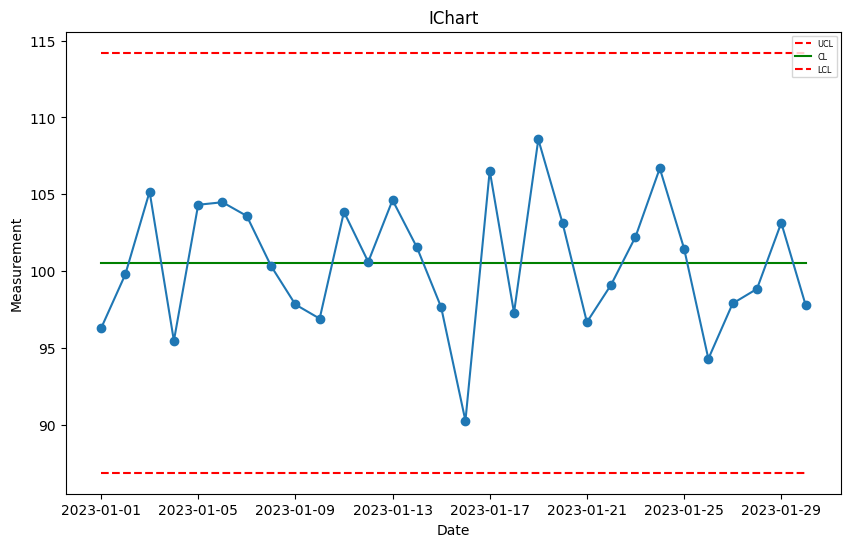

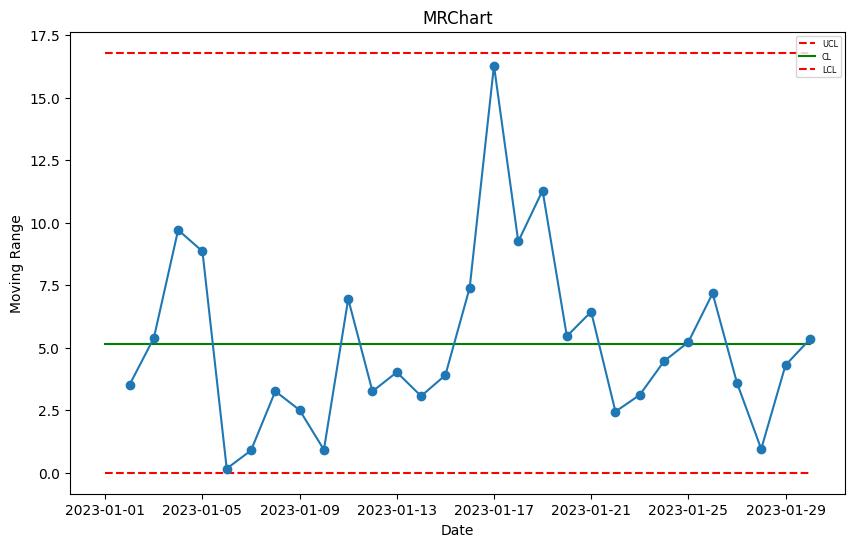

In [2]:
import pandas as pd
from spc_toolbox import IChart, MRChart

df = pd.read_csv("data/I-MRChart.csv")
df["Date"] = pd.to_datetime(df["Date"])

iChart = IChart()
mrChart = MRChart()

iChart.fit(index=df["Date"], values=df["Measurement"], n=2)
iChart.plot()

mrChart.fit(index=df["Date"], values=df["Measurement"], n=2)
mrChart.plot()

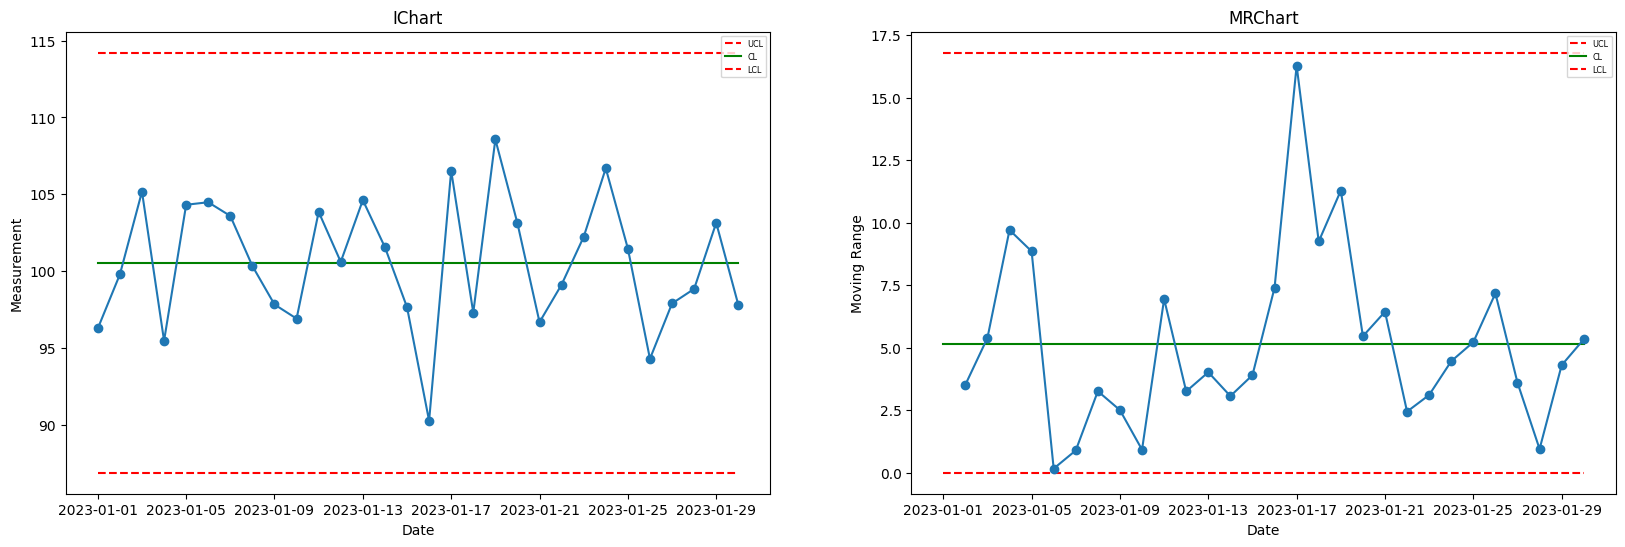

In [3]:
from spc_toolbox import ControlChart
import numpy as np
import pandas as pd
from spc_toolbox import IChart, MRChart

df = pd.read_csv("data/I-MRChart.csv")
df["Date"] = pd.to_datetime(df["Date"])

iChart = IChart()
mrChart = MRChart()

(iChart & mrChart).fit(index=df["Date"], values=df["Measurement"], n=2).plot()

IChart  \
   rule_one_point_gt_3_sigma   
0                      False   
1                      False   
2                      False   
3                      False   
4                      False   
5                      False   
6                      False   
7                      False   
8                      False   
9                      False   
10                     False   
11                     False   
12                     False   
13                     False   
14                     False   
15                     False   
16                     False   
17                     False   
18                     False   
19                     False   
20                     False   
21                     False   
22                     False   
23                     False   
24                     False   
25                     False   
26                     False   
27                     False   
28                     False   
29                     False   

                                                           \
   rule_9_points_in_a_row_on_the_same_side_of_center_line   
0                                               False       
1                                               False       
2                                               False       
3                                               False       
4                                               False       
5                                               False       
6                                               False       
7                                               False       
8                                               False       
9                                               False       
10                                              False       
11                                              False       
12                                              False       
13                                              False       
14                                              False       
15                                              False       
16                                              False       
17                                              False       
18                                              False       
19                                              False       
20                                              False       
21                                              False       
22                                              False       
23                                              False       
24                                              False       
25                                              False       
26                                              False       
27                                              False       
28                                              False       
29                                              False       

                                                                 \
   rule_6_points_in_a_row_continuously_increasing_or_decreasing   
0                                               False             
1                                               False             
2                                               False             
3                                               False             
4                                               False             
5                                               False             
6                                               False             
7                                               False             
8                                               False             
9                                               False             
10                                              False             
11                                              False             
12                                              False             
13                                     

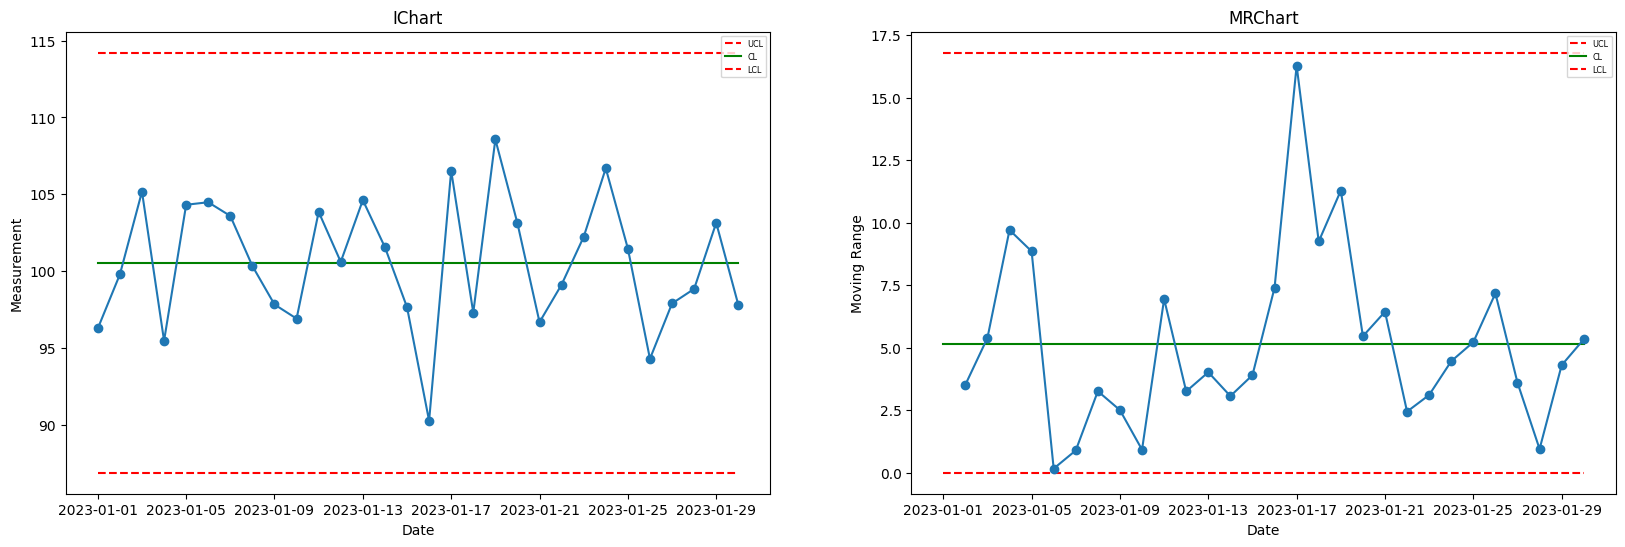

In [4]:
from spc_toolbox import ControlChart
import numpy as np
import pandas as pd
from spc_toolbox import IChart, MRChart

df = pd.read_csv("data/I-MRChart.csv")
df["Date"] = pd.to_datetime(df["Date"])

iChart = IChart()
mrChart = MRChart()

(iChart & mrChart).fit(index=df["Date"], values=df["Measurement"], n=2)

def rule_one_point_gt_k_sigma(chart: ControlChart, k: float) -> pd.Series:
    deviation = chart.y - chart.center_line
    return deviation.abs() > (chart.sigma * k)

def rule_k_points_same_side(chart: ControlChart, k: int) -> pd.Series:
    side = (chart.y > chart.center_line).astype(int)
    return side.rolling(window=k).sum().isin([0, k])

def rule_k_points_all_increasing_or_decreasing(chart: ControlChart, k: int) -> pd.Series:
    diff = chart.y.diff()
    increasing = (diff > 0).astype(int).rolling(window=k-1).sum() == (k-1)
    decreasing = (diff < 0).astype(int).rolling(window=k-1).sum() == (k-1)
    return increasing | decreasing

def rule_k_points_alternating(chart: ControlChart, k: int) -> pd.Series:
    diff = chart.y.diff().fillna(0)
    signs = diff.apply(np.sign)
    alternates = signs != signs.shift()
    return alternates.rolling(window=k).sum() == k

def rule_k_out_of_k1_points_2sigma(chart: ControlChart, k: int) -> pd.Series:
    deviation = chart.y - chart.center_line
    condition = deviation.abs() > (2 * chart.sigma)
    return condition.rolling(window=k+1).sum() >= k

def rule_k_out_of_k1_points_1sigma(chart: ControlChart, k: int) -> pd.Series:
    deviation = chart.y - chart.center_line
    condition = deviation.abs() > chart.sigma
    return condition.rolling(window=k+1).sum() >= k

def rule_k_points_within_1sigma(chart: ControlChart, k: int) -> pd.Series:
    deviation = chart.y - chart.center_line
    condition = deviation.abs() <= chart.sigma
    return condition.rolling(window=k).sum() == k

def rule_k_points_gt_1sigma(chart: ControlChart, k: int) -> pd.Series:
    deviation = chart.y - chart.center_line
    condition = deviation.abs() > chart.sigma
    return condition.rolling(window=k).sum() == k

rules = {
    "rule_one_point_gt_3_sigma": lambda chart: rule_one_point_gt_k_sigma(chart, 3),
    "rule_9_points_in_a_row_on_the_same_side_of_center_line": lambda chart: rule_k_points_same_side(chart, 9),
    "rule_6_points_in_a_row_continuously_increasing_or_decreasing": lambda chart: rule_k_points_all_increasing_or_decreasing(chart, 6),
    "rule_14_points_in_a_row_alternating_up_and_down": lambda chart: rule_k_points_alternating(chart, 14),
    "rule_2_out_of_3_points_gt_2_sigma": lambda chart: rule_k_out_of_k1_points_2sigma(chart, 2),
    "rule_4_out_of_5_points_gt_1_sigma": lambda chart: rule_k_out_of_k1_points_1sigma(chart, 4),
    "rule_15_points_in_a_row_within_1_sigma": lambda chart: rule_k_points_within_1sigma(chart, 15),
    "rule_8_points_in_a_row_outside_1_sigma": lambda chart: rule_k_points_gt_1sigma(chart, 8)
}

(iChart & mrChart).add_rules(rules)
(iChart & mrChart).plot()
results = (iChart & mrChart).evaluate_rules(rules)
results_df = pd.concat((pd.DataFrame(v) for v in results.values()), axis=1, keys=list(results.keys()))
results_df